In [79]:
import json
import ast
import os
from os import path
from tqdm import tqdm
from tld import get_fld
from IPython.display import display_markdown, Image

import pandas as pd
pd.options.plotting.backend = "plotly"

import plotly.io as pio
import plotly.express as px
blue = px.colors.qualitative.Plotly[0]
red = px.colors.qualitative.Plotly[1]
green = px.colors.qualitative.Plotly[2]

def printMD(txt):
    display_markdown(txt, raw=True)

In [107]:
import copy
my_template = copy.deepcopy(pio.templates["plotly_white"])
my_template.layout.margin = dict(l=0, b=0, r=0, t=0, pad=0)
my_template.layout.font.color = "black"
my_template.layout.legend.xanchor = "right"
my_template.layout.legend.yanchor = "top"
pio.templates.default = my_template

## Load crawl data from JSON files

In [2]:
def loadDataFromFolder(folder_name: str):
    DATA_PATH_PREFIX = "/mnt/data/MT/"
    folder_path = path.join(DATA_PATH_PREFIX, folder_name)
    
    def isCrawlDataFile(filename: str):
        return filename.endswith(".json") and filename != "metadata.json" and path.isfile(path.join(folder_path, filename))
    
    json_files = [f for f in os.listdir(folder_path) if isCrawlDataFile(f)]
    print("Found %d JSON files" % len(json_files))

    all_sites = []
    all_calls = []
    for filename in tqdm(json_files):
        with open(path.join(folder_path, filename)) as file:
            crawl_data = json.load(file)
            initial_url = crawl_data["initialUrl"]
            final_url = crawl_data["finalUrl"]
            all_sites.append({
                "initialUrl": initial_url,
                "finalUrl": final_url,
                "timeout": crawl_data["timeout"]
            })

            # Sort saved calls
            ps_data = crawl_data["data"]["privacySandbox"]
            if not ps_data:
                continue

            subpages = ps_data["crawledSubpages"]

            saved_calls = ps_data["savedCalls"]
            if len(saved_calls) == 0:
                continue

            for saved_call in saved_calls:
                si = saved_call["subpageIndex"]
                saved_call["initialUrl"] = subpages[si]["initialUrl"] if si >= 0 else initial_url
                saved_call["finalUrl"] = subpages[si]["finalUrl"] if si >= 0 else final_url
                all_calls.append(saved_call)

    pd.DataFrame(all_sites).to_csv(f"{folder_name}-sites.csv", index=False)
    del all_sites

    pd.DataFrame(all_calls).to_csv(f"{folder_name}-calls.csv", index=False)
    del all_calls

In [3]:
loadDataFromFolder("10k-crawl-eu")

Found 8266 JSON files


100%|██████████| 8266/8266 [02:43<00:00, 50.60it/s]


In [4]:
loadDataFromFolder("10k-crawl-us")

Found 7598 JSON files


100%|██████████| 7598/7598 [02:25<00:00, 52.17it/s]


## Analyzing the crawl data

In [70]:
sites_df = []
calls_df = []
for region in ["eu", "us"]:
    calls = pd.read_csv(f"10k-crawl-{region}-calls.csv")
    calls["region"] = region.upper()
    calls["finalUrlFld"] = calls["finalUrl"].apply(lambda d: get_fld(d))
    calls["sourceFld"] = calls["source"].apply(get_fld)
    calls_df.append(calls)

    sites = pd.read_csv(f"10k-crawl-{region}-sites.csv")
    sites["region"] = region.upper()
    sites["finalUrlFld"] = sites["finalUrl"].apply(lambda d: get_fld(d, fail_silently=True))
    sites_df.append(sites)

    nr_of_distinct_sites = sites["finalUrlFld"].nunique()
    print(f"{region.upper()}: {nr_of_distinct_sites} distinct sites ({len(sites) - nr_of_distinct_sites} finalUrlFld duplicates), "
            + f"{len(sites[sites['timeout']])} timeouts, {10000 - len(sites)} failures (did not produce data)")

sites_df = pd.concat(sites_df)
calls_df = pd.concat(calls_df)

display(calls_df.head())

EU: 7849 distinct sites (417 finalUrlFld duplicates), 386 timeouts, 1734 failures (did not produce data)
US: 7209 distinct sites (389 finalUrlFld duplicates), 442 timeouts, 2402 failures (did not produce data)


,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,region,finalUrlFld,sourceFld
0,https://gum.criteo.com/syncframe?origin=publis...,Document.browsingTopics,{},{},call,https://gum.criteo.com/syncframe?origin=publis...,https://www.15min.lt/,-1,http://15min.lt/,https://www.15min.lt/,EU,15min.lt,criteo.com
1,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': True}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.15min.lt/,-1,http://15min.lt/,https://www.15min.lt/,EU,15min.lt,doubleclick.net
2,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': False}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.15min.lt/,-1,http://15min.lt/,https://www.15min.lt/,EU,15min.lt,doubleclick.net
3,https://eus.rubiconproject.com/usync.js,Document.browsingTopics,{},{},call,https://eus.rubiconproject.com/usync.html?p=pb...,https://www.15min.lt/,-1,http://15min.lt/,https://www.15min.lt/,EU,15min.lt,rubiconproject.com
4,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': True}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.15min.lt/,-1,http://15min.lt/,https://www.15min.lt/,EU,15min.lt,doubleclick.net


In [71]:
total_sites = sites_df.groupby("region")["finalUrlFld"].size()
distinct_sites = sites_df.groupby("region")["finalUrlFld"].nunique()
duplicate_sites = (total_sites - distinct_sites).to_frame("Duplicates")
failure_sites = (10000 - total_sites).to_frame("Failures")
df = distinct_sites.to_frame("Success").join([duplicate_sites, failure_sites]).reset_index()

display(df)

,region,Success,Duplicates,Failures
0,EU,7849,417,1734
1,US,7209,389,2402


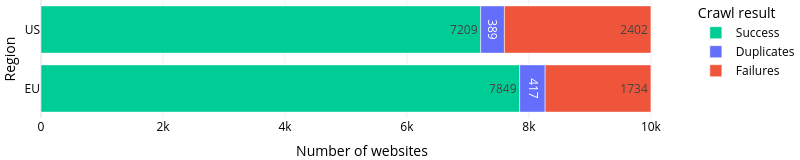

In [111]:
fig = df.plot.bar(
    x = ["Success", "Duplicates", "Failures"],
    y = "region",
    # title = "The crawl result of the 10,000 websites crawled",
    labels = {
        "description": "Method name",
        "calls": "Number of calls",
        "region": "Region",
        "variable": "Crawl result",
        "value": "Number of websites"
    },
    text_auto = True,
    color_discrete_sequence=[green, blue, red]
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        xanchor="left",
    )
)
fig.write_image("../../mt-latex/figures/crawl-result.pdf", width=800, height=160)
Image(fig.to_image(format="png", width=800, height=160))

In [3]:
sites_df[sites_df["finalUrlFld"].isnull()].sort_values(by="initialUrl")

,initialUrl,finalUrl,timeout,region,finalUrlFld
5069,http://allegro.pl/,chrome-error://chromewebdata/,True,US,None
4171,http://autohome.com.cn/,chrome-error://chromewebdata/,True,EU,None
7379,http://baomoi.com/,chrome-error://chromewebdata/,True,EU,None
6301,http://cafef.vn/,chrome-error://chromewebdata/,True,EU,None
1269,http://kenh14.vn/,chrome-error://chromewebdata/,True,EU,None
3977,http://kokoatv.net/,about:blank,False,US,None
2074,http://kuaishou.com/,chrome-error://chromewebdata/,True,US,None
4210,http://mca.gov.in/,about:blank,False,US,None
8177,http://mca.gov.in/,about:blank,False,EU,None
3357,http://nld.com.vn/,chrome-error://chromewebdata/,True,EU,None


^ *Some sites seem to redirect to Chrome error pages, about:blank, or IP-addresses, which means they don't have a final FLD, which means they were counted as failures in the numbers above (`nunique` does not count `None` values by default)*

In [89]:
sites_df[sites_df["finalUrlFld"].isnull()].groupby("region").size()

region
EU    14
US     8
dtype: int64

In [90]:
calls_df[calls_df["finalUrlFld"].isnull()].sort_values(by="initialUrl")

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,region,finalUrlFld,sourceFld


In [91]:
sites_df["finalUrl"].describe()

count                     15864
unique                     8564
top       https://xhamster.com/
freq                         17
Name: finalUrl, dtype: object

In [92]:
sites_df["finalUrlFld"].describe()

count          15842
unique          8013
top       google.com
freq              41
Name: finalUrlFld, dtype: object

In [93]:
sites_df[sites_df["finalUrlFld"] == "google.com"]

,initialUrl,finalUrl,timeout,region,finalUrlFld
229,http://web.app/,https://firebase.google.com/products/hosting/,False,EU,google.com
304,http://apps.chrome/,https://www.google.com/chromebook/apps/,False,EU,google.com
306,http://appspot.com/,https://accounts.google.com/v3/signin/identifi...,False,EU,google.com
474,http://google.us/,https://www.google.com/,False,EU,google.com
481,http://googlesyndication.com/,https://www.google.com/?gws_rd=ssl,False,EU,google.com
1444,http://ensighten.com/,https://www.google.com/,False,EU,google.com
2369,http://anichin.art/,https://www.google.com/,False,EU,google.com
3030,http://firebaseapp.com/,https://firebase.google.com/products/hosting/,False,EU,google.com
3788,http://doubleclick.net/,https://marketingplatform.google.com/about/ent...,False,EU,google.com
3976,http://feedburner.com/,https://accounts.google.com/v3/signin/identifi...,False,EU,google.com


In [94]:
sites_df[sites_df["finalUrlFld"] == "google.com"]["initialUrl"].nunique()

21

#### Number of websites on which we collected API calls:

In [95]:
calls_df.groupby("description")["finalUrlFld"].nunique()

description
Document.browsingTopics           2572
Navigator.joinAdInterestGroup      447
Navigator.leaveAdInterestGroup     157
Navigator.runAdAuction             276
Name: finalUrlFld, dtype: int64

^ *Distinct websites with calls from US or EU*

In [96]:
eu_sites = sites_df[sites_df["region"] == "EU"].drop_duplicates(subset="finalUrlFld")
us_sites = sites_df[sites_df["region"] == "US"].drop_duplicates(subset="finalUrlFld")
merged_sites = eu_sites.merge(us_sites, on="finalUrlFld", how="outer", indicator=True)

printMD("#### Sites only successfully crawled in the EU:")
display(merged_sites[merged_sites["_merge"] == "left_only"][["finalUrlFld", "_merge"]])

printMD("#### Sites only successfully crawled in the US:")
display(merged_sites[merged_sites["_merge"] == "right_only"][["finalUrlFld", "_merge"]])

printMD("#### Sites successfully crawled in both the EU and the US:")
display(merged_sites[merged_sites["_merge"] == "both"][["finalUrlFld", "_merge"]])

#### Sites only successfully crawled in the EU:

,finalUrlFld,_merge
7,10jqka.com.cn,left_only
16,15min.lt,left_only
20,17track.net,left_only
34,liveabout.com,left_only
38,livehindustan.com,left_only
...,...,...
7748,chicagotribune.com,left_only
7781,mumsnet.com,left_only
7784,musescore.com,left_only
7825,meteofor.com.ua,left_only


#### Sites only successfully crawled in the US:

,finalUrlFld,_merge
7850,20min.ch,right_only
7851,fancode.com,right_only
7852,wfwf295.com,right_only
7853,wfxs.com.tw,right_only
7854,wholefoodsmarket.com,right_only
...,...,...
8009,yggtorrent.wtf,right_only
8010,sephora.com,right_only
8011,intelbras.com,right_only
8012,rajasthan.gov.in,right_only


#### Sites successfully crawled in both the EU and the US:

,finalUrlFld,_merge
0,0123movie.net,both
1,037hdmovie.com,both
2,0gomovies.gd,both
3,1000.menu,both
4,10086.cn,both
...,...,...
7845,twinrdsyte.com,both
7846,twitcasting.tv,both
7847,twitch.tv,both
7848,twitpic.com,both


### On which sites are the APIs being called?

#### Number of collected calls for the Topics API and Protected Audience API per region

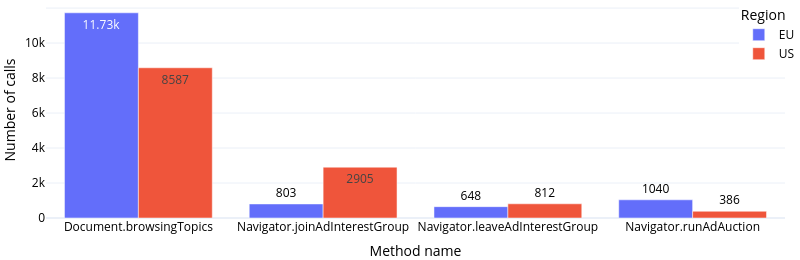

In [120]:
fig = calls_df.groupby(["region", "description"]).size().reset_index(name="calls").plot.bar(
    x = "description",
    y = "calls",
    color = "region",
    barmode = "group",
    # title = "Number of collected calls for the Topics API and Protected Audience API per region",
    labels = {
        "description": "Method name",
        "calls": "Number of calls",
        "region": "Region"
    },
    text_auto = True
)
printMD("#### Number of collected calls for the Topics API and Protected Audience API per region")
fig.write_image("../../mt-latex/figures/calls-per-call-type.pdf", width=800, height=260)
Image(fig.to_image(format="png", width=800, height=260))

#### Number of distinct websites with calls to the Topics API and Protected Audience API per region

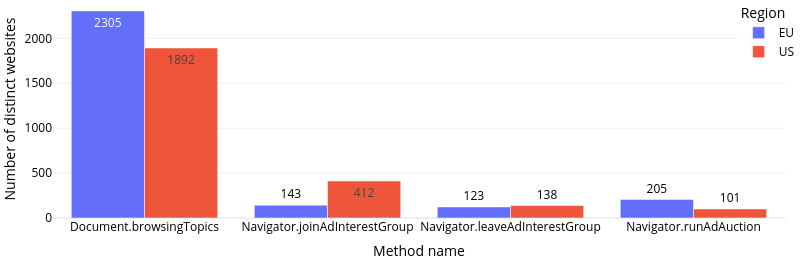

In [119]:
fig = calls_df.groupby(["region", "description"])["finalUrlFld"].nunique().reset_index(name="nr_of_distinct_websites").plot.bar(
    x = "description",
    y = "nr_of_distinct_websites",
    color = "region",
    barmode = "group",
    # title = "Number of distinct websites with calls to the Topics API and Protected Audience API per region",
    labels = {
        "description": "Method name",
        "nr_of_distinct_websites": "Number of distinct websites",
        "region": "Region"
    },
    text_auto = True
)
printMD("#### Number of distinct websites with calls to the Topics API and Protected Audience API per region")
fig.write_image("../../mt-latex/figures/distinct-websites-per-call-type.pdf", width=800, height=260)
Image(fig.to_image(format="png", width=800, height=260))


In [6]:
for call_type, call_data in calls_df.groupby("description"):
    data_per_region = []
    regions = []
    for region, region_call_data in call_data.groupby("region"):
        regions.append(region)
        data_per_region.append(region_call_data.groupby("finalUrlFld")["sourceFld"]
                               .describe().sort_values(by="count", ascending=False))
        # display(data_per_region[-1].head(10))

    combined_data = pd.concat(data_per_region, axis=1, keys=regions)
    printMD(f"{len(call_data)} calls for `{call_type}`, on {len(combined_data)} distinct sites:")
    display(combined_data.head(10))

20317 calls for `Document.browsingTopics`, on 2572 distinct sites:

EU                                    US         \
                  count unique                 top freq count unique   
finalUrlFld                                                            
diezminutos.es       98      6  rubiconproject.com   36    75      6   
fotogramas.es        90      6  rubiconproject.com   35    48      6   
lavozdegalicia.es    83      7          criteo.com   18    11      4   
crcldu.com           75      3          criteo.com   65   NaN    NaN   
femmeactuelle.fr     59      3          criteo.com   30    43      3   
zulily.com           53      4     creativecdn.com   47    44      4   
sporcle.com          52      4          criteo.com   26   NaN    NaN   
elnacional.cat       48      8          criteo.com   13   NaN    NaN   
sensacine.com        44      8  rubiconproject.com   10    38      4   
diariouno.com.ar     38      3     doubleclick.net   35   NaN    NaN   

                                            
                                  top freq  
finalUrlFld                                 
diezminutos.es     rubiconproject.com   32  
fotogramas.es      rubiconproject.com   16  
lavozdegalicia.es     doubleclick.net    5  
crcldu.com                        NaN  NaN  
femmeactuelle.fr           criteo.com   17  
zulily.com            creativecdn.com   38  
sporcle.com                       NaN  NaN  
elnacional.cat                    NaN  NaN  
sensacine.com         doubleclick.net   16  
diariouno.com.ar                  NaN  NaN

3708 calls for `Navigator.joinAdInterestGroup`, on 447 distinct sites:

EU                                 US         \
                      count unique              top freq count unique   
finalUrlFld                                                             
asics.com                48      2         teads.tv   46     2      1   
patagonia.com            33      1  doubleclick.net   33    16      1   
banggood.com             25      1  doubleclick.net   25    26      1   
boots.com                23      1  doubleclick.net   23    23      1   
levi.com                 22      1  doubleclick.net   22    16      1   
vistaprint.com           21      1  doubleclick.net   21   NaN    NaN   
hbomax.com               18      1  doubleclick.net   18   NaN    NaN   
podbean.com              18      1  doubleclick.net   18    19      1   
halloweencostumes.com    18      1  doubleclick.net   18    24      1   
reolink.com              18      1  doubleclick.net   18    17      1   

                                             
                                   top freq  
finalUrlFld                                  
asics.com                     teads.tv    2  
patagonia.com          doubleclick.net   16  
banggood.com           doubleclick.net   26  
boots.com              doubleclick.net   23  
levi.com               doubleclick.net   16  
vistaprint.com                     NaN  NaN  
hbomax.com                         NaN  NaN  
podbean.com            doubleclick.net   19  
halloweencostumes.com  doubleclick.net   24  
reolink.com            doubleclick.net   17

1460 calls for `Navigator.leaveAdInterestGroup`, on 157 distinct sites:

EU                                 US         \
                count unique              top freq count unique   
finalUrlFld                                                       
vistaprint.com     95      1  doubleclick.net   95    46      1   
mailchimp.com      80      1  doubleclick.net   80    80      1   
klaviyo.com        61      1  doubleclick.net   61    66      1   
smbcnikko.co.jp    20      1  doubleclick.net   20    70      1   
ruangguru.com      14      1  doubleclick.net   14    14      1   
reolink.com        14      1  doubleclick.net   14    14      1   
webex.com          12      1  doubleclick.net   12    12      1   
hilton.com         12      1  doubleclick.net   12    12      1   
se.com             12      1  doubleclick.net   12    12      1   
easeus.com         11      1  doubleclick.net   11     9      1   

                                       
                             top freq  
finalUrlFld                            
vistaprint.com   doubleclick.net   46  
mailchimp.com    doubleclick.net   80  
klaviyo.com      doubleclick.net   66  
smbcnikko.co.jp  doubleclick.net   70  
ruangguru.com    doubleclick.net   14  
reolink.com      doubleclick.net   14  
webex.com        doubleclick.net   12  
hilton.com       doubleclick.net   12  
se.com           doubleclick.net   12  
easeus.com       doubleclick.net    9

1426 calls for `Navigator.runAdAuction`, on 276 distinct sites:

EU                                 US         \
                     count unique              top freq count unique   
finalUrlFld                                                            
tattle.life             86      1  doubleclick.net   86   NaN    NaN   
as.com                  31      1  doubleclick.net   31   NaN    NaN   
androidauthority.com    23      1  doubleclick.net   23   NaN    NaN   
gsp.ro                  20      1  doubleclick.net   20   NaN    NaN   
cope.es                 19      3  doubleclick.net   17     1      1   
aksam.com.tr            16      1  doubleclick.net   16   NaN    NaN   
pinkvilla.com           16      2  doubleclick.net   15   NaN    NaN   
punchng.com             16      2  doubleclick.net   12   NaN    NaN   
pulzo.com               16      1  doubleclick.net   16   NaN    NaN   
gadgets360.com          15      2  doubleclick.net   13   NaN    NaN   

                                        
                              top freq  
finalUrlFld                             
tattle.life                   NaN  NaN  
as.com                        NaN  NaN  
androidauthority.com          NaN  NaN  
gsp.ro                        NaN  NaN  
cope.es               seedtag.com    1  
aksam.com.tr                  NaN  NaN  
pinkvilla.com                 NaN  NaN  
punchng.com                   NaN  NaN  
pulzo.com                     NaN  NaN  
gadgets360.com                NaN  NaN

Pilot crawl 2:
- 629 calls for `Document.browsingTopics`, on 98 distinct sites (13.41% of all successfully crawled sites)
- 141 calls for `Navigator.joinAdInterestGroup`, on 24 distinct sites (3.28% of all successfully crawled sites)
- 34 calls for `Navigator.runAdAuction`, on 4 distinct sites (0.55% of all successfully crawled sites)

Pilot crawl 3:
- 514 calls for `Document.browsingTopics`, on 108 distinct sites (17.5% of all successfully crawled sites)
- 468 calls for `Navigator.joinAdInterestGroup`, on 63 distinct sites (10.2% of all successfully crawled sites)
- 7 calls for `Navigator.runAdAuction`, on 2 distinct sites (0.3% of all successfully crawled sites)

Since the 4th pilot crawl we now also collect `Navigator.leaveAdInterestGroup` and `Navigator.updateAdInterestGroups`

Pilot crawl 4:
- 640 calls for `Document.browsingTopics`, on 135 distinct sites (22.2% of all successfully crawled sites)
- 548 calls for `Navigator.joinAdInterestGroup`, on 63 distinct sites (10.3% of all successfully crawled sites)
- 356 calls for `Navigator.leaveAdInterestGroup`, on 27 distinct sites (4.4% of all successfully crawled sites)
- 0 calls for `Navigator.runAdAuction`

### From which sources are the API calls coming?

In [7]:
for call_type, call_data in calls_df.groupby("description"):
    data_per_region = []
    regions = []
    for region, region_call_data in call_data.groupby("region"):
        regions.append(region)
        data_per_region.append(region_call_data.groupby(["sourceFld"])["finalUrlFld"]
                               .describe().sort_values(by="unique", ascending=False))

    combined_data = pd.concat(data_per_region, axis=1, keys=regions)
    printMD(f"{call_data['finalUrlFld'].nunique()} websites with calls for `{call_type}`, from {len(combined_data)} distinct callers:")
    display(combined_data.head(20))

2572 websites with calls for `Document.browsingTopics`, from 65 distinct callers:

EU                                      US         \
                    count unique                   top freq count unique   
sourceFld                                                                  
doubleclick.net      3743   1047      diariouno.com.ar   35  1905    500   
licdn.com            1894    951           verizon.com    8  1972    969   
criteo.com           2036    933            crcldu.com   65  1390    586   
rubiconproject.com   2277    599        diezminutos.es   36  2080    422   
taboola.com           698    364  karlsruhe-insider.de    9   418    223   
creativecdn.com       374    203            zulily.com   47   329    155   
ladsp.com              85     19                qvc.jp   15   102     21   
weborama.fr            40     17           fontanka.ru    8    32     15   
pubmatic.com           85     16        diezminutos.es   17    34      8   
wpadmngr.com           27     15       indianporn.site    3    28     15   
top100.ru              45     15                 vc.ru   14    37     13   
authorizedvault.com    79     14        diezminutos.es   17    33      7   
sunmedia.tv            80     13        diezminutos.es   18    39      7   
ay.delivery            16     11            finviz.com    2     8      4   
edkt.io                21     11          scotsman.com    2     3      2   
sda.fyi                16      8  simplypsychology.org    2    13      7   
teads.tv               68      8         mailchimp.com   12    56      8   
ad-score.com           10      8         icy-veins.com    2     9      7   
78387c2566.com          9      5           amaporn.com    4     9      5   
bustle.com             10      5        elitedaily.com    2   NaN    NaN   

                                                
                                      top freq  
sourceFld                                       
doubleclick.net                 marca.com   45  
licdn.com                     verizon.com    8  
criteo.com                       wykop.pl   26  
rubiconproject.com             genytb.net   58  
taboola.com          karlsruhe-insider.de    8  
creativecdn.com                zulily.com   38  
ladsp.com                      k-manga.jp   18  
weborama.fr                         vc.ru    3  
pubmatic.com               diezminutos.es   13  
wpadmngr.com              indianporn.site    3  
top100.ru                           vc.ru   12  
authorizedvault.com        diezminutos.es   13  
sunmedia.tv                diezminutos.es   13  
ay.delivery                 icy-veins.com    4  
edkt.io                        cityam.com    2  
sda.fyi                    hackspirit.com    2  
teads.tv                    mailchimp.com   12  
ad-score.com                icy-veins.com    2  
78387c2566.com                amaporn.com    4  
bustle.com                            NaN  NaN

447 websites with calls for `Navigator.joinAdInterestGroup`, from 6 distinct callers:

EU                                    US         \
                count unique                 top freq count unique   
sourceFld                                                            
doubleclick.net   740    135       patagonia.com   33  2876    401   
teads.tv           51      4           asics.com   46    11      4   
seedtag.com         3      2  parlons-basket.com    2     1      1   
creativecdn.com     2      1        rtbhouse.com    2     2      1   
ladsp.com           5      1           mintj.com    5    10      3   
microad.jp          2      1       microad.co.jp    2     5      2   

                                     
                           top freq  
sourceFld                            
doubleclick.net    samsung.com  152  
teads.tv           pandora.net    6  
seedtag.com          marca.com    1  
creativecdn.com   rtbhouse.com    2  
ladsp.com            mintj.com    5  
microad.jp       microad.co.jp    4

157 websites with calls for `Navigator.leaveAdInterestGroup`, from 2 distinct callers:

EU                                US                        \
                count unique             top freq count unique            top   
sourceFld                                                                       
doubleclick.net   619    108  vistaprint.com   95   796    128  mailchimp.com   
retargetly.com     29     15     rappler.com    3    16     10    epsilon.com   

                      
                freq  
sourceFld             
doubleclick.net   80  
retargetly.com     2

276 websites with calls for `Navigator.runAdAuction`, from 3 distinct callers:

EU                                US         \
                      count unique             top freq count unique   
sourceFld                                                              
doubleclick.net         876    144     tattle.life   86   205     40   
googlesyndication.com   109     47   sportsport.ba   14   131     43   
seedtag.com              55     27  e-noticies.cat    5    50     22   

                                          
                                top freq  
sourceFld                                 
doubleclick.net        20minutos.es   35  
googlesyndication.com     disway.id   30  
seedtag.com            rugbyrama.fr    5

^ *Note: why does Retargetly call `leaveAdInterestGroup` but not `joinAdInterestGroup`?*

- `count`: total number of calls per caller
- `unique`: number of unique websites the caller appears on
- `top`: website with the most calls from the caller
- `freq`: number of calls for the `top` website

### Analyzing `joinAdInterestGroup` calls

In [123]:
join_calls = calls_df[calls_df["description"] == "Navigator.joinAdInterestGroup"].copy()
join_calls["arguments"] = join_calls["arguments"].map(ast.literal_eval) # they were turned into strings after putting them in a CSV

seconds_to_days = 1 / (60 * 60 * 24)
join_calls["duration"] = join_calls["arguments"].apply(lambda arg: int(arg["1"]) * seconds_to_days)

for subArg in ["owner", "name"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg))

for subArg in ["ads", "adComponents"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg, []))
    join_calls[f"{subArg}Len"] = join_calls[subArg].apply(lambda ads: len(ads))

display(join_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,region,finalUrlFld,sourceFld,duration,owner,name,ads,adsLen,adComponents,adComponentsLen
28,https://td.doubleclick.net/td/rul/804139102?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/804139102?ra...,https://www.livechat.com/,-1,http://livechat.com/,https://www.livechat.com/,EU,livechat.com,doubleclick.net,14.0,https://td.doubleclick.net,1j7122563249,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,2,[],0
30,https://td.doubleclick.net/td/rul/804139102?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/804139102?ra...,https://www.livechat.com/,0,https://www.livechat.com/marketplace/,https://www.livechat.com/marketplace/,EU,livechat.com,doubleclick.net,14.0,https://td.doubleclick.net,1j7122563249,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,2,[],0
32,https://td.doubleclick.net/td/rul/804139102?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/804139102?ra...,https://www.livechat.com/,-1,http://livechatinc.com/,https://www.livechat.com/,EU,livechat.com,doubleclick.net,14.0,https://td.doubleclick.net,1j7122563249,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,2,[],0


#### Interest group owners

In [124]:
join_calls.groupby("owner")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
owner,,,,
https://td.doubleclick.net,3616,436,samsung.com,152
https://fledge.teads.tv,62,5,asics.com,48
https://fledge.ladsp.com,15,3,mintj.com,10
https://t.seedtag.com,4,2,marca.com,2
https://f.creativecdn.com,4,1,rtbhouse.com,4
https://privacy-sandbox-ot.send.microad.jp,6,1,microad.co.jp,6
https://track.u.send.microad.jp,1,1,cmoa.jp,1


- `count`: total number of calls per owner
- `unique`: number of unique websites the owner appears on
- `top`: website with the most calls from the owner
- `freq`: number of calls for the `top` website

#### Durations/lifetime of interest groups
According to the [documentation](https://developer.chrome.com/docs/privacy-sandbox/protected-audience-api/interest-groups/#example-usage), the duration of interest groups is capped at 30 days (2592000 seconds).

#### Interest group duration per owner

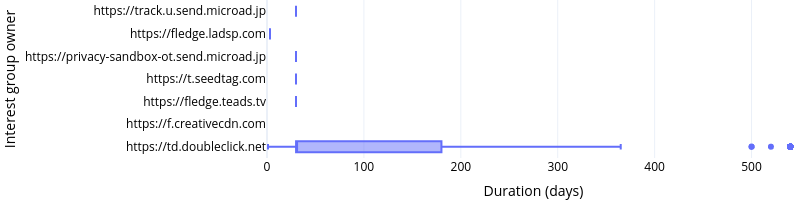

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://f.creativecdn.com,4.0,30000.000000,0.000000,30000.0,30000.0,30000.0,30000.0,30000.0
https://fledge.ladsp.com,15.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
https://fledge.teads.tv,62.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0
https://privacy-sandbox-ot.send.microad.jp,6.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0
https://t.seedtag.com,4.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0
https://td.doubleclick.net,3616.0,126.569967,177.863471,1.0,30.0,30.0,180.0,540.0
https://track.u.send.microad.jp,1.0,30.000000,NaN,30.0,30.0,30.0,30.0,30.0


In [129]:
fig = join_calls.boxplot(
    x = "duration",
    y = "owner",
    # title = "Interest group duration per owner",
    labels = {
        "owner": "Interest group owner",
        "duration": "Duration (days)"
    }
)
fig.update(layout_xaxis_range = [0, 550]) # otherwise creativecdn.com ruins our plot
printMD("#### Interest group duration per owner")
display(Image(fig.to_image(format="png", width=800, height=200)))

display(join_calls.groupby("owner")["duration"].describe())

In [12]:
join_calls[join_calls["owner"] == "https://f.creativecdn.com"]["arguments"].apply(lambda arg: arg["1"])

842     2592000000
849     2592000000
1889    2592000000
1895    2592000000
Name: arguments, dtype: int64

^ *I think `creativecdn.com` accidentally put the duration of their interest groups in milliseconds instead of seconds, causing the duration to be 30,000 days... (although this is of course limited by the API itself)*

#### Number of ads per interest group

Number of ads per interest group

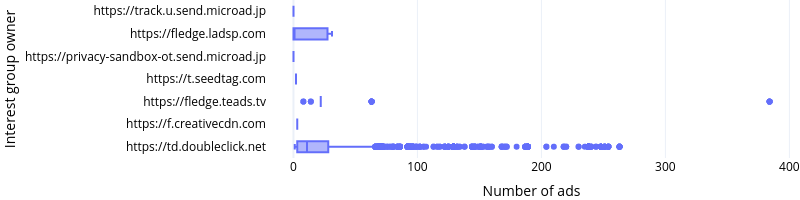

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://f.creativecdn.com,4.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
https://fledge.ladsp.com,15.0,10.800000,14.072262,0.0,0.0,0.0,25.0,31.0
https://fledge.teads.tv,62.0,48.612903,89.705411,8.0,22.0,22.0,22.0,384.0
https://privacy-sandbox-ot.send.microad.jp,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
https://t.seedtag.com,4.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
https://td.doubleclick.net,3616.0,25.173949,42.430950,1.0,3.0,11.0,28.0,263.0
https://track.u.send.microad.jp,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0


In [130]:
fig = join_calls.boxplot(
    x = "adsLen",
    y = "owner",
    # title = "Number of ads per interest group",
    labels = {
        "adsLen": "Number of ads",
        "owner": "Interest group owner"
    }
)
printMD("Number of ads per interest group")
display(Image(fig.to_image(format="png", width=800, height=200)))

join_calls.groupby("owner")["adsLen"].describe()

#### Sites with the largest number of ads in a single interest group

In [131]:
for source, data in join_calls[["sourceFld", "finalUrlFld", "adsLen"]].groupby("sourceFld"):
    printMD("Interest groups with most ads for `%s`:" % source)
    display(data.groupby("finalUrlFld").max(numeric_only=True).sort_values("adsLen", ascending=False).head(10))

Interest groups with most ads for `creativecdn.com`:

,adsLen
finalUrlFld,
rtbhouse.com,3


Interest groups with most ads for `doubleclick.net`:

,adsLen
finalUrlFld,
winzip.com,263
stubhub.com,254
thriftbooks.com,251
timeshighereducation.com,248
alison.com,248
casetify.com,244
upwork.com,240
chewy.com,238
grammarly.com,210


Interest groups with most ads for `ladsp.com`:

,adsLen
finalUrlFld,
mintj.com,31
furusato-tax.jp,0
k-manga.jp,0


Interest groups with most ads for `microad.jp`:

,adsLen
finalUrlFld,
cmoa.jp,0
microad.co.jp,0


Interest groups with most ads for `seedtag.com`:

,adsLen
finalUrlFld,
marca.com,2
parlons-basket.com,2


Interest groups with most ads for `teads.tv`:

,adsLen
finalUrlFld,
fairmont.com,384
pandora.net,63
asics.com,22
kia.com,14
ouraring.com,8


#### Some example `renderUrl`'s from the ads

In [132]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "doubleclick.net") & (join_calls["finalUrlFld"] == "winzip.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderUrl')}`\n"
    if len(txt) > 1600:
        txt += "- ..."
        break
printMD(txt)

- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=683161710613&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=632413743562&cv_id=1&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=656686266190&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=668159477445&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=680245629598&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=680245629721&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=680245629724&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=136383537280&cr_id=680245629727&cv_id=0&format=${AD_WIDTH}x${AD_HEIGHT}&gdpr=${GDPR}&gdpr_consent=${GDPR_CONSENT_0}&addtl_consent=${ADDTL_CONSENT}&rds=${RENDER_DATA}`
- ...

^ *Looks like DoubleClick is using more mysterious URL parameters in addition to the previously seen `${RENDER_DATA}`, like `${GDPR}`, `${GDPR_CONSENT_0}`, and`${ADDTL_CONSENT}`. Apparently these are [registered ad macros](https://github.com/WICG/turtledove/blob/main/Fenced_Frames_Ads_Reporting.md#registeradmacro) that come from `registerAdMacro()` calls in the `reportWin()` function called when an ad wins the auction*

In [133]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "teads.tv") & (join_calls["finalUrlFld"] == "fairmont.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderUrl')}`\n"
    if len(txt) > 800:
        txt += "- ..."
        break
printMD(txt)

- `https://fledge.teads.tv/v1/render/ad/1085370/1148835`
- `https://fledge.teads.tv/v1/render/ad/1085370/1148836`
- `https://fledge.teads.tv/v1/render/ad/1085370/1148837`
- `https://fledge.teads.tv/v1/render/ad/1085370/1148838`
- `https://fledge.teads.tv/v1/render/ad/1085370/1148839`
- `https://fledge.teads.tv/v1/render/ad/1085370/1148840`
- `https://fledge.teads.tv/v1/render/ad/1085370/1152239`
- `https://fledge.teads.tv/v1/render/ad/1085370/1152244`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151579`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151580`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151581`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151582`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151583`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151584`
- `https://fledge.teads.tv/v1/render/ad/1088388/1151668`
- ...

#### Number of ad components per interest group

Number of ad components per interest group

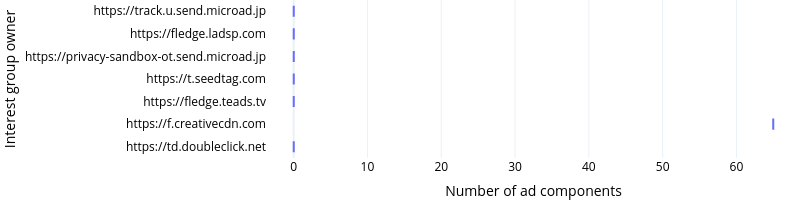

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://f.creativecdn.com,4.0,65.0,0.0,65.0,65.0,65.0,65.0,65.0
https://fledge.ladsp.com,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://fledge.teads.tv,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://privacy-sandbox-ot.send.microad.jp,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://t.seedtag.com,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://td.doubleclick.net,3616.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://track.u.send.microad.jp,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [134]:
fig = join_calls.boxplot(
    x = "adComponentsLen",
    y = "owner",
    # title = "Number of ad components per interest group",
    labels = {
        "adComponentsLen": "Number of ad components",
        "owner": "Interest group owner"
    }
)
printMD("Number of ad components per interest group")
display(Image(fig.to_image(format="png", width=800, height=200)))

join_calls.groupby("owner")["adComponentsLen"].describe()

^ *Only `creativecdn.com` is using ad components currently*

### Analyzing `runAdAuction` calls

In [135]:
auction_calls = calls_df[calls_df["description"] == "Navigator.runAdAuction"].copy()
auction_calls["arguments"] = auction_calls["arguments"].map(ast.literal_eval)

auction_calls["seller"] = auction_calls["arguments"].apply(lambda arg: arg["0"].get("seller"))

for subArg in ["componentAuctions", "interestGroupBuyers"]:
    auction_calls[subArg] = auction_calls["arguments"].apply(lambda arg: arg["0"].get(subArg, []))
    auction_calls[f"{subArg}Len"] = auction_calls[subArg].apply(lambda ads: len(ads))

display(auction_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,region,finalUrlFld,sourceFld,seller,componentAuctions,componentAuctionsLen,interestGroupBuyers,interestGroupBuyersLen
64,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://slobodnadalmacija.hr/spiza,NaN,0,https://slobodnadalmacija.hr/spiza,https://slobodnadalmacija.hr/spiza,EU,slobodnadalmacija.hr,doubleclick.net,https://securepubads.g.doubleclick.net,[{'seller': 'https://securepubads.g.doubleclic...,1,[],0
65,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://slobodnadalmacija.hr/spiza,NaN,0,https://slobodnadalmacija.hr/spiza,https://slobodnadalmacija.hr/spiza,EU,slobodnadalmacija.hr,doubleclick.net,https://securepubads.g.doubleclick.net,[{'seller': 'https://securepubads.g.doubleclic...,1,[],0
66,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://slobodnadalmacija.hr/spiza,NaN,0,https://slobodnadalmacija.hr/spiza,https://slobodnadalmacija.hr/spiza,EU,slobodnadalmacija.hr,doubleclick.net,https://securepubads.g.doubleclick.net,[{'seller': 'https://securepubads.g.doubleclic...,1,[],0


In [136]:
auction_calls[""].describe()

KeyError: ''

#### Who are the auction sellers?

In [ ]:
auction_calls.groupby("seller")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
seller,,,,
https://securepubads.g.doubleclick.net,1321,248,tattle.life,86
https://t.seedtag.com,105,33,e-noticies.cat,9


- `count`: total number of calls per seller
- `unique`: number of unique websites the seller appears on
- `top`: website with the most calls from the seller
- `freq`: number of calls for the `top` website

#### Component auctions

In [ ]:
auction_calls.groupby("seller")["componentAuctions"].describe()

,count,unique,top,freq
seller,,,,
https://securepubads.g.doubleclick.net,1321,1212,[{'seller': 'https://securepubads.g.doubleclic...,100
https://t.seedtag.com,105,1,[],105


In [ ]:
auction_calls.groupby("seller")["componentAuctionsLen"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
https://securepubads.g.doubleclick.net,1321.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
https://t.seedtag.com,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


^ *DoubleClick seems to always use component auctions*

#### Interest Group Buyers

In [ ]:
auction_calls.groupby("seller")["interestGroupBuyers"].describe()

,count,unique,top,freq
seller,,,,
https://securepubads.g.doubleclick.net,1321,1,[],1321
https://t.seedtag.com,105,4,[https://t.seedtag.com],70


In [ ]:
auction_calls.groupby("seller")["interestGroupBuyersLen"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
https://securepubads.g.doubleclick.net,1321.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
https://t.seedtag.com,105.0,1.142857,0.447827,1.0,1.0,1.0,1.0,3.0


^ *DoubleClick has no "main" interest group buyers, but they do have interest group buyers in the component auctions*

In [ ]:
auction_calls[auction_calls["seller"] == "https://securepubads.g.doubleclick.net"]["componentAuctions"].map(lambda auc: auc[0]["interestGroupBuyers"]).describe()

count                                                  1321
unique                                                    3
top       [https://f.creativecdn.com, https://googleads....
freq                                                   1065
Name: componentAuctions, dtype: object

In [ ]:
print(auction_calls[auction_calls["seller"] == "https://securepubads.g.doubleclick.net"]["componentAuctions"].map(lambda auc: str(auc[0]["interestGroupBuyers"])).unique())

["['https://f.creativecdn.com', 'https://googleads.g.doubleclick.net', 'https://td.doubleclick.net']"
 "['https://f.creativecdn.com']"
 "['https://googleads.g.doubleclick.net', 'https://td.doubleclick.net']"]


In [ ]:
auction_calls[auction_calls["seller"] == "https://t.seedtag.com"]["interestGroupBuyers"].describe()

count                         105
unique                          4
top       [https://t.seedtag.com]
freq                           70
Name: interestGroupBuyers, dtype: object

In [ ]:
print(auction_calls[auction_calls["seller"] == "https://t.seedtag.com"]["interestGroupBuyers"].apply(str).unique())

["['https://t.seedtag.com']"
 "['https://f.creativecdn.com', 'https://f.creativecdn.com']"
 "['https://f.creativecdn.com']"
 "['https://f.creativecdn.com', 'https://f.creativecdn.com', 'https://f.creativecdn.com']"]


^ *Why does Seedtag include `f.creativecdn.com` sometimes two or three times?*

### Who uses key/value-services?

In [ ]:
join_calls["trustedBiddingSignalsUrl"] = join_calls["arguments"].apply(lambda arg: arg["0"].get("trustedBiddingSignalsUrl"))

def getTrustedScoringSignalUrl(arg: str):
    arg = arg["0"]
    url = arg.get("trustedScoringSignalsUrl")
    if url:
        return url
    
    # Get first scoring signal URL from component auction if there is no main scoring signal URL
    for arg in arg.get("componentAuctions", []):
        url = arg.get("trustedScoringSignalsUrl")
        if url:
            return url
    
    return None    

auction_calls["trustedScoringSignalsUrl"] = auction_calls["arguments"].apply(getTrustedScoringSignalUrl)

#### Trusted bidding signals URLs per owner:

In [ ]:
data_per_region = []
regions = []
for region, region_data in join_calls.groupby("region"):
    regions.append(region)
    data_per_region.append(region_data.groupby(["owner"])["trustedBiddingSignalsUrl"]
                            .describe().sort_values(by="count", ascending=False))

combined_data = pd.concat(data_per_region, axis=1, keys=regions)
display(combined_data)

EU         \
                                           count unique   
owner                                                     
https://td.doubleclick.net                   740      1   
https://fledge.teads.tv                       51      1   
https://t.seedtag.com                          3      1   
https://f.creativecdn.com                      2      1   
https://privacy-sandbox-ot.send.microad.jp     2      1   
https://fledge.ladsp.com                       0      0   
https://track.u.send.microad.jp              NaN    NaN   

                                                                                               \
                                                                                          top   
owner                                                                                           
https://td.doubleclick.net                                  https://td.doubleclick.net/td/bts   
https://fledge.teads.tv                     https://fledge.teads.tv/v1/bidding/trusted-sig...   
https://t.seedtag.com                       https://t.seedtag.com/ps/buyer/bidding-signal....   
https://f.creativecdn.com                        https://f.creativecdn.com/bidder/tbsweb/bids   
https://privacy-sandbox-ot.send.microad.jp  https://privacy-sandbox-ot.send.microad.jp/tbs...   
https://fledge.ladsp.com                                                                  NaN   
https://track.u.send.microad.jp                                                           NaN   

                                                   US         \
                                           freq count unique   
owner                                                          
https://td.doubleclick.net                  740  2876      1   
https://fledge.teads.tv                      51    11      1   
https://t.seedtag.com                         3     1      1   
https://f.creativecdn.com                     2     2      1   
https://privacy-sandbox-ot.send.microad.jp    2     4      1   
https://fledge.ladsp.com                    NaN     0      0   
https://track.u.send.microad.jp             NaN     1      1   

                                                                                               \
                                                                                          top   
owner                                                                                           
https://td.doubleclick.net                                  https://td.doubleclick.net/td/bts   
https://fledge.teads.tv                     https://fledge.teads.tv/v1/bidding/trusted-sig...   
https://t.seedtag.com                       https://t.seedtag.com/ps/buyer/bidding-signal....   
https://f.creativecdn.com                        https://f.creativecdn.com/bidder/tbsweb/bids   
https://privacy-sandbox-ot.send.microad.jp  https://privacy-sandbox-ot.send.microad.jp/tbs...   
https://fledge.ladsp.com                                                                  NaN   
https://track.u.send.microad.jp                           https://track.u.send.microad.jp/tbs   

                                                  
                                            freq  
owner                                             
https://td.doubleclick.net                  2876  
https://fledge.teads.tv                       11  
https://t.seedtag.com                          1  
https://f.creativecdn.com                      2  
https://privacy-sandbox-ot.send.microad.jp     4  
https://fledge.ladsp.com                     NaN  
https://track.u.send.microad.jp                1

In [ ]:
join_calls.groupby(["region", "owner"]).count()

source  description  \
region owner                                                             
EU     https://f.creativecdn.com                        2            2   
       https://fledge.ladsp.com                         5            5   
       https://fledge.teads.tv                         51           51   
       https://privacy-sandbox-ot.send.microad.jp       2            2   
       https://t.seedtag.com                            3            3   
       https://td.doubleclick.net                     740          740   
US     https://f.creativecdn.com                        2            2   
       https://fledge.ladsp.com                        10           10   
       https://fledge.teads.tv                         11           11   
       https://privacy-sandbox-ot.send.microad.jp       4            4   
       https://t.seedtag.com                            1            1   
       https://td.doubleclick.net                    2876         2876   
       https://track.u.send.microad.jp                  1            1   

                                                   arguments  returnValue  \
region owner                                                                
EU     https://f.creativecdn.com                           2            2   
       https://fledge.ladsp.com                            5            5   
       https://fledge.teads.tv                            51           51   
       https://privacy-sandbox-ot.send.microad.jp          2            2   
       https://t.seedtag.com                               3            3   
       https://td.doubleclick.net                        740          740   
US     https://f.creativecdn.com                           2            2   
       https://fledge.ladsp.com                           10           10   
       https://fledge.teads.tv                            11           11   
       https://privacy-sandbox-ot.send.microad.jp          4            4   
       https://t.seedtag.com                               1            1   
       https://td.doubleclick.net                       2876         2876   
       https://track.u.send.microad.jp                     1            1   

                                                   accessType  frameURL  \
region owner                                                              
EU     https://f.creativecdn.com                            2         2   
       https://fledge.ladsp.com                             5         5   
       https://fledge.teads.tv                             51        51   
       https://privacy-sandbox-ot.send.microad.jp           2         2   
       https://t.seedtag.com                                3         3   
       https://td.doubleclick.net                         740       740   
US     https://f.creativecdn.com                            2         2   
       https://fledge.ladsp.com                            10        10   
       https://fledge.teads.tv                             11        11   
       https://privacy-sandbox-ot.send.microad.jp           4         4   
       https://t.seedtag.com                                1         1   
       https://td.doubleclick.net                        2876      2876   
       https://track.u.send.microad.jp                      1         1   

                                                   referrer  subpageIndex  \
region owner                                                                
EU     https://f.creativecdn.com                          2             2   
       https://fledge.ladsp.com                           5             5   
       https://fledge.teads.tv                           51            51   
       https://privacy-sandbox-ot.send.microad.jp         2             2   
       https://t.seedtag.com                              3             3   
       https://td.doubleclick.net                       691           740   
US     https://f.creativecdn.com          

^ *Only `fledge.ladsp.com` doesn't seem to use a key/value service for their calls to `joinAdInterestGroup`, the other owners all do use a key/value service (which is the same URL for all collected calls per owner)*

#### Trusted scoring signals URLs per seller

In [ ]:
data_per_region = []
regions = []
for region, region_data in auction_calls.groupby("region"):
    regions.append(region)
    data_per_region.append(region_data.groupby(["seller"])["trustedScoringSignalsUrl"]
                            .describe().sort_values(by="count", ascending=False))

combined_data = pd.concat(data_per_region, axis=1, keys=regions)
display(combined_data)

EU         \
                                       count unique   
seller                                                
https://securepubads.g.doubleclick.net   985      1   
https://t.seedtag.com                      0      0   

                                                                                       \
                                                                                  top   
seller                                                                                  
https://securepubads.g.doubleclick.net  https://securepubads.g.doubleclick.net/td/sts   
https://t.seedtag.com                                                             NaN   

                                               US         \
                                       freq count unique   
seller                                                     
https://securepubads.g.doubleclick.net  985   336      1   
https://t.seedtag.com                   NaN     0      0   

                                                                                       \
                                                                                  top   
seller                                                                                  
https://securepubads.g.doubleclick.net  https://securepubads.g.doubleclick.net/td/sts   
https://t.seedtag.com                                                             NaN   

                                             
                                       freq  
seller                                       
https://securepubads.g.doubleclick.net  336  
https://t.seedtag.com                   NaN

In [ ]:
auction_calls.groupby(["region", "seller"]).count()

source  description  arguments  \
region seller                                                                   
EU     https://securepubads.g.doubleclick.net     985          985        985   
       https://t.seedtag.com                       55           55         55   
US     https://securepubads.g.doubleclick.net     336          336        336   
       https://t.seedtag.com                       50           50         50   

                                               returnValue  accessType  \
region seller                                                            
EU     https://securepubads.g.doubleclick.net          985         985   
       https://t.seedtag.com                            55          55   
US     https://securepubads.g.doubleclick.net          336         336   
       https://t.seedtag.com                            50          50   

                                               frameURL  referrer  \
region seller                                                       
EU     https://securepubads.g.doubleclick.net       985       234   
       https://t.seedtag.com                         55         1   
US     https://securepubads.g.doubleclick.net       336       167   
       https://t.seedtag.com                         50         0   

                                               subpageIndex  initialUrl  \
region seller                                                             
EU     https://securepubads.g.doubleclick.net           985         985   
       https://t.seedtag.com                             55          55   
US     https://securepubads.g.doubleclick.net           336         336   
       https://t.seedtag.com                             50          50   

                                               finalUrl  finalUrlFld  \
region seller                                                          
EU     https://securepubads.g.doubleclick.net       985          985   
       https://t.seedtag.com                         55           55   
US     https://securepubads.g.doubleclick.net       336          336   
       https://t.seedtag.com                         50           50   

                                               sourceFld  \
region seller                                              
EU     https://securepubads.g.doubleclick.net        985   
       https://t.seedtag.com                          55   
US     https://securepubads.g.doubleclick.net        336   
       https://t.seedtag.com                          50   

                                               trustedScoringSignalsUrl  
region seller                                                            
EU     https://securepubads.g.doubleclick.net                       985  
       https://t.seedtag.com                                          0  
US     https://securepubads.g.doubleclick.net                       336  
       https://t.seedtag.com                                          0

^ *`t.seedtag.com` doesn't seem to use a key/value service for their calls to `runAdAuction()`, but DoubleClick does for all their calls*

### Did the calls come from crawled subpages?

In [138]:
subpage_calls = calls_df.groupby("description")["subpageIndex"].value_counts().unstack().fillna(0)
display(subpage_calls)

subpageIndex,-1,0
description,,
Document.browsingTopics,9835,10482
Navigator.joinAdInterestGroup,1825,1883
Navigator.leaveAdInterestGroup,605,855
Navigator.runAdAuction,594,832


In [139]:
calls_df.groupby("description")["subpageIndex"].value_counts().unstack(level=1).reset_index().melt(id_vars="description", value_vars=[-1, 0])

,description,subpageIndex,value
0,Document.browsingTopics,-1,9835
1,Navigator.joinAdInterestGroup,-1,1825
2,Navigator.leaveAdInterestGroup,-1,605
3,Navigator.runAdAuction,-1,594
4,Document.browsingTopics,0,10482
5,Navigator.joinAdInterestGroup,0,1883
6,Navigator.leaveAdInterestGroup,0,855
7,Navigator.runAdAuction,0,832


Number of collected calls per subpage

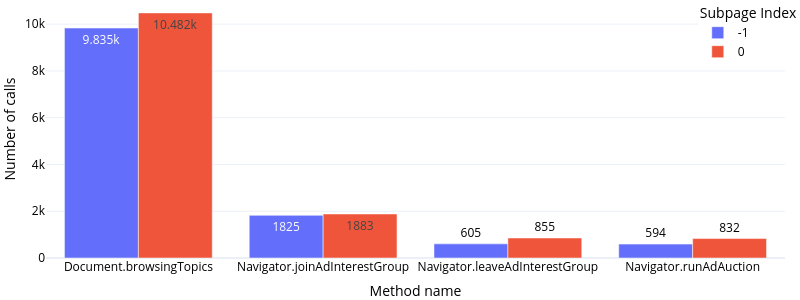

In [143]:
fig = subpage_calls.reset_index().melt(id_vars="description", value_vars=[-1, 0]).plot.bar(
    # title = "Number of collected calls per subpage",
    x = "description",
    y = "value",
    color = "subpageIndex",
    barmode = "group",
    labels = {
        "description": "Method name",
        "value": "Number of calls",
        "subpageIndex": "Subpage Index",
        
    },
    text_auto = True
)
printMD("Number of collected calls per subpage")
display(Image(fig.to_image(format="png", width=800, height=300)))

In [141]:
first_subpage_calls = calls_df.groupby(["description", "finalUrlFld"])["subpageIndex"].min().reset_index(level="finalUrlFld")["subpageIndex"] \
    .groupby("description").value_counts().unstack().fillna(0)
display(first_subpage_calls)

subpageIndex,-1,0
description,,
Document.browsingTopics,2283,289
Navigator.joinAdInterestGroup,402,45
Navigator.leaveAdInterestGroup,124,33
Navigator.runAdAuction,183,93


First occurrence of a method call per site

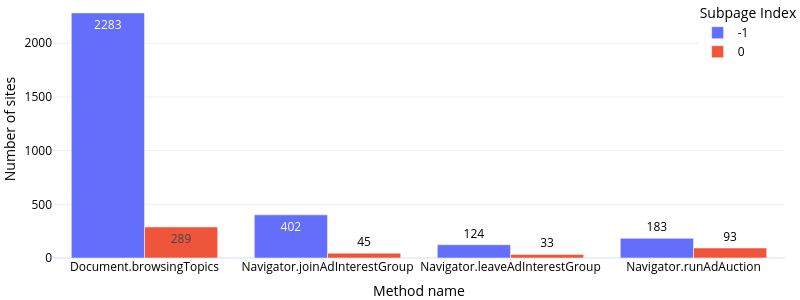

In [144]:
fig = first_subpage_calls.reset_index().melt(id_vars="description", value_vars=[-1, 0]).plot.bar(
    # title = "First occurrence of a method call per site",
    x = "description",
    y = "value",
    color = "subpageIndex",
    barmode = "group",
    labels = {
        "description": "Method name",
        "value": "Number of sites",
        "subpageIndex": "Subpage Index",
        
    },
    text_auto = True
)
printMD("First occurrence of a method call per site")
display(Image(fig.to_image(format="png", width=800, height=300)))